# 11.뉴스 요약봇 만들기

## 1. 들어가며
긴 문장을 짧게 요약해주는 텍스트 요약기를 만들어보자

텍스트 요약은 끊임 없이 늘어나는 정보를 쉽고 빠르게 소화하기 위해서 굉장히 중요한 기술이다. 구글에서 검색되는 페이지들로만 해도 600억개의 페이지정도가 있다. 아마 숨겨지거나, 검색되지 않은 페이지들을 합치면 그 수는 훨씬 클것이다. 게다가 인터넷은 계속해서 커지고 있으니, 이 모든 페이지를 다 소화하기는 무리일 것이다.

여기에서 텍스트 요약(Text Summarization)기술이 나타나 이 큰 정보들을 소화할 수 있도록 도와주는 것이다.

### 학습 목표
---
* Extractive/Abstractive summarization 이해하기
* 단어장 크기를 줄이는 다양한 text normalization 적용해보기
* seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

## 2. 텍스트 요약(Text Summarization)이란?

<img src="./image/textsum.png" alt="Text Summarization" />

텍스트 요약(Text Summarization)이란 위 그림과 같이 긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것을 말한다. 예를 들어 상대적으로 큰 텍스트인 뉴스 기사로 작은 텍스트인 뉴스 제목을 만들어내는 것이 텍스트 요약의 대표적인 예라고 할 수 있다.

이때 중요한 것은 요약 전후에 정보 손실 발생이 최소화되어야 한다는 점이다. 이것은 정보를 압축하는 과정과 같다. 비록 텍스트의 길이가 크게 줄어들었지만, 요약문은 문서 원문이 담고 있는 정보를 최대한 보존하고 있어야 한다. 이것은 원문의 길이가 길수록 만만치 않은 어려운 작업이 된다. 사람이 이 작업을 수행한다 하더라도 긴 문장을 정확하게 읽고 이해한 후, 그 의미를 손상하지 않는 짧은 다른 표현으로 원문을 번역해 내야 하는 것이다.

그렇게 요약 문장을 만들어 내려면 어떤 방법을 사용하면 좋을까? 여기서 텍스트 요약은 크게 추출적 요약(Extractive Summarization)과 추상적 요약(Abstractive Summarization)의 두가지 접근으로 나누어볼 수 있다.

### 추출적 요약(Extractive Summarization)
---
첫번째 방식인 추출적 요약은 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식이다. 가령, 10개의 문장으로 구성된 텍스트가 있다면, 그 중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식이다. 그런데 꺼내온 3개의 문장이 원문에서 중요한 문장일 수는 있어도, 3개의 문장의 연결이 자연스럽지 않을 수는 있다. 결과로 나온 문장들 간의 호응이 자연스럽지 않을 수 있다는 것이다. 딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 텍스트랭크([TextRank](https://www.aclweb.org/anthology/W04-3252.pdf))와 같은 알고리즘을 사용해서 이 방법을 사용한다고 한다.

이런 방식을 이미 서비스에 도입해서 활용하고 있는 사례가 있다. 가장 대표적인 것이 네이버 뉴스 서비스에 있는 `요약봇` 기능이다.

[네이버 뉴스](https://news.naver.com/)에 접속해서 아무 뉴스 기사나 클릭해 보자. 제목 우하단의 `요약봇` 버튼을 다시 클릭해 보면, 기사 원문을 단 3줄로 요약한 글을 볼 수 있다. 가끔은 세 문장간 연결이 조금 매끄럽지 않게 느껴질 때도 있지만 꽤 그럴듯한 요약문으로 보인다. 위에서 소개한 TextRank 알고리즘을 통해 해당 기사를 가장 잘 대표하는 단어들로 이루어진 핵심문장을 아주 효과적으로 찾아내기 때문이다. 잘 찾아보면 요약문에 사용된 문장 3개가 원문에 그대로 있다는 것을 알 수 있다.

### 추상적 요약(Abstractive Summarization)
---
두번째 방식인 추상적 요약은 추출적 요약보다 좀 더 흥미로운 접근을 사용한다. 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것이다. 여기서 __새로운 문장__이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미한다. 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역인 셈이다. 반면, 추출적 요약은 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수 있을 것이다.

자연어 생성하면 혹시 떠오르는 신경망이 있을 것이다. 가장 기본적인 신경망 중 하나인 RNN으로 이 문제를 풀 수 있다 그렇다면, RNN으로 추상적 요약 방식을 구현한다고 하면 문제가 전혀 없을까?

RNN은 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 문제가 있다. 이 문제를 해결하기 위해 LSTM과 GRU가 등장했고, 이 둘도 부족해서 어텐션(Attention) 메커니즘이 등장했다.

이 문제를 장기 의존성(long term dependencies) 문제라고 한다.

그저 RNN을 이용해 Language Generation을 한다고 해서 긴 문장을 읽고 나서 요약문을 뚝딱 만들어내긴 어렵다. 어떤 방법을 사용할 지 고민을 할 때, 잘 하는 사람들의 것들을 보는 것도 도움이 된다. ML 분야의 선구자라고 할 수 있는 기업 '구글(Google)'은 자신들의 서비스에 어떤 방식으로 텍스트 요약을 시도했었을까? 2016년의 아래 기사에 따르면, 구글은 뉴스 기사 내용으로부터 자동으로 뉴스 제목을 뽑아내는 텍스트 요약 모델을 구현했었다고 한다. 어떻게 구현했는지, 읽어보자.

* [구글 인공지능 "뉴스 제목도 잘 뽑네"](https://zdnet.co.kr/view/?no=20160905114833&from=Mobile)

구글이 메일서비스에 적용한 자동 회신(Smart Reply) 기능을 만든 것과 비슷한 딥러닝 기법이기도 한 인코더와 디코더의 구조로 구성된 이 딥 러닝 아키텍처를 __seq2seq(sequence-to-sequence)__라고 한다.

## 3. 인공 신경망으로 텍스트 요약 훈련시키기

seq2seq 모델을 통해서 Abstractive summarization 방식의 텍스트 요약기를 만들어볼것이다. seq2seq은 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해내는 자연어 생성 모델이다. 주로 뉴럴 기계번역에 사용되는 이 모델이 텍스트 요약에도 사용될 수 있을지 갸우뚱하실 수도 있겠지만, 원문을 요약문으로 번역한다고 생각한다면 전혀 무리가 없다.

### seq2seq 개요
---

<img src="./image/s2s.png" alt="seq2seq" />

원문을 첫번째 RNN인 인코더로 입력하면, 인코더는 이를 하나의 고정된 벡터로 변환한다. 이 벡터를 문맥 정보를 가지고 있는 벡터라고 하여 컨텍스트 벡터(context vector)라고 한다. 두번째 RNN인 디코더는 이 컨텍스트 벡터를 전달받아 한 단어씩 생성해내서 요약 문장을 완성한다.

seq2seq를 쉽게 풀어준 영상이 있다. 
[![노마드 코더](https://img.youtube.com/vi/WsQLdu2JMgI/0.jpg)](https://youtu.be/WsQLdu2JMgI)

### LSTM과 컨텍스트 벡터
---
seq2seq를 구현할 때, 인코더/디코더로 바닐라 RNN이 아니라 LSTM을 사용할 것이다.

<img src="./image/lstm.png" alt="LSTM" />

LSTM이 바닐라 RNN과 다른 점은 다음 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달한다는 점이다. 다시 말해, 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state h와 cell state c 두 개의 값 모두 존재해야 한다는 뜻이다.

### 시작 토큰과 종료 토큰
---
<img src="./image/encoder_decoder.png" alt="시작 토큰과 종료 토큰" />

seq2seq 구조에서 디코더는 시작 토큰 SOS가 입력되면, 각 시점마다 단어를 생성하고 이 과정을 종료 토큰 EOS를 예측하는 순간까지 멈추지않는다. 다시 말해 훈련 데이터의 예측 대상 시퀀스의 앞, 뒤에는 시작 토큰과 종료 토큰을 넣어주는 전처리를 통해 어디서 멈춰야하는지 알려줄 필요가 있다.

### 어텐션 메커니즘을 통한 새로운 컨텍스트 벡터 사용하기
---
<img src="./image/Attention_Mechanism.png" alt="Attention Mechanism" />

기존에 배운 seq2seq를 수정하고, 새로운 모듈을 붙여 모델의 성능을 높여볼것이다. 기존의 seq2seq는 __인코더의 마지막 time step의 hidden state__를 컨텍스트 벡터로 사용했다. 하지만 RNN 계열의 인공 신경망(바닐라 RNN, LSTM, GRU)의 한계로 인해 이 컨텍스트 정보에는 이미 입력 시퀀스의 많은 정보가 손실이 된 상태가 된다.

__어텐션 메커니즘(Attention Mechanism)__은 이와 달리, __인코더의 모든 step의 hidden state의 정보__가 컨텍스트 벡터에 전부 반영되도록 하는 것이다. 하지만 인코더의 모든 hidden state가 동일한 비중으로 반영되는 것이 아니라, 디코더의 <span style="color:red">현재 time step</span>의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식이다.

위 그림의 예로 들자면, seq2seq 모델이라면 디코더로 전달되는 인코더의 컨텍스트 벡터는 인코더의 마지막 스텝의 hidden state인 $h_{5}$가 되겠지만, 어텐션 메커니즘이 적용된 seq2seq인 Attentional seq2seq이라면 인코더의 컨텍스트 벡터는 예를 들어 __0.2__$h_{1}$+__0.3__$h_{2}$+__0.1__$h_{3}$+__0.15__$h_{4}$+__0.25__$h_{5}$가 될수도 있다는 말이다.

여기서 주의해야 할 것은, 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 __디코더의 현재 스텝이 어디냐에 따라 계속 달라진다__는 점이다. 즉, 디코더의 현재 문장 생성 부위가 주어부인지 술어부인지 목적어인지 등에 따라 인코더가 입력 데이터를 해석한 컨텍스트 벡터가 다른 값이 된다는 것이다. 이와 달리, 기본적인 seq2seq 모델에서 컨텍스트 벡터는 디코더의 현재 스텝 위치에 무관하게 한번 계산되면 고정값을 가진다.

이렇게 디코더의 현재 스텝에 따라 동적으로 달라지는 인코더의 컨텍스트 벡터를 사용해서 현재의 예측에 활용하면, 디코더가 좀 더 정확한 예측을 할 수 있게 된다. 이러한 Attention 기법은 seq2seq을 비롯하여 향후 다양한 딥러닝 분야를 획기적으로 발전시킨 핵심 개념이 된다. 특히 자연어처리 분야에서는 두말할 것도 없다.

지금까지 내용 정리.

1. seq2seq를 사용한다.
2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 한다.
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙인다.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작한다.
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산한다.
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측한다.

## 4. 데이터 준비하기
아래와 같이 작업환경을 구성한다.

```bash
$ mkdir -p ~/aiffel/news_summarization/data
```

텍스트 요약 모델 학습에 사용할 데이터셋은 Kaggle에서 제공된 `아마존 리뷰 데이터셋`이다.

링크 : [https://www.kaggle.com/snap/amazon-fine-food-reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)

위 링크에서 Reviews.csv 파일(286.97 MB)을 다운로드 받아 위에 생성한 디렉토리에 넣자. 혹은 아래와 같이 진행해도 된다.

```bash
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/Reviews.csv.zip
$ mv Reviews.csv.zip ~/aiffel/news_summarization/data
$ cd ~/aiffel/news_summarization/data && unzip Reviews.csv.zip
```

이번에는 NLTK의 불용어(stopwords)를 사용할 것이다. NTLK와 NLTK 데이터셋이 설치되어있지 않은 환경이라면 우선 NLTK를 설치하고 NTLK의 데이터셋을 다운로드해야한다.

NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리이다. 이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어있다. 이를 이용해 다운로드받은 리뷰 파일에서 불용어를 제거하는 작업을 진행할 예정이다.

터미널을 열어 아래 명령어를 실행해 NLTK 데이터셋을 다운로드한다.

```bash
$ pip install nltk
```

BeautifulSoup 라이브러리도 설치하지 않았다면 설치해야한다. BeautifulSoup는 문서를 파싱하는데 사용하는 패키지이다.

```bash
$ pip install beautifulsoup4
```

nltk 패키지에서 불용어 사전을 다운로드 받고, 데이터 전처리를 위한 나머지 패키지도 함께 불러와보자.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


링크에서 다운로드 받은 데이터(Reviews.csv)는 총 568,454개의 샘플을 갖고있다. 시간상 여기서는 모든 샘플을 사용하지는 않고, 간단히 10만개의 샘플만 사용해보자. 데이터 파일의 경로를 수정하는 것을 잊지말아야 한다.

In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows = 100000)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 100000


출력된 샘플수를 보면 총 10만개의 샘플이 잘 불러와진 것을 확인할 수 있다. 이 중에 5개만 출력해보자

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


열이 너무 많아서 보기에 조금 까다롭다. 사실 전체 데이터 중 Summary 열과 Text 열 만 훈련에 사용할 거라, 이 두 개의 열만 별도로 저장하고, 다시 출력해보자.

In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
74006,I added the Taco Bell Chipotle Sauce to BBQ ch...,Smoke and Spice How Nice
99146,I got the sampler pack first and tried to find...,Best of the Vegan Dream Jerky
20604,This is probably the best flavored coffee I an...,Awesome
18394,I was SO excited to have found tea that tastes...,NOTHING like Aveda Tea
50194,I ordered one package and wished I had ordered...,I like these sausages.
34468,This cofee is perfect for me. Not really dark...,good coffee
24674,i first started looking into gluten free foods...,yummy!
62624,I dithered about purchasing this product. I am...,Smooth
41894,"These are dry but not hard, slightly crumbly, ...",My dog loves them
63538,I've tried both the illy issimo Caffe and the ...,"Good, but not as good as the Cappuccino"


2개의 열이 남았다. Text 열의 내용을 요약한 것이 Summary 열이다. 여기서는 인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킬 것이다.

## 5. 데이터 전처리하기 (1) 데이터 정리하기
이제 데이터를 불러왔으니 전처리를 진행해보자. 빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아낼것이다.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거
---
우선 데이터의 중복 샘플 유무를 확인해보자.

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


중복을 제외한다면 Text에는 88,426개, Summary에는 72,348개의 의 유니크한 데이터가 존재한다. 사실 이 데이터의 Summary는 'Smelly'나 'Good Product'와 같이 아주 간단한 요약들도 많아서 Text가 달라도 Summary는 동일할 수 있다. 하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야한다.

데이터프레임의 `drop_duplicates()`를 사용하면, 손쉽게 중복 샘플을 제거할 수 있다.

In [6]:
data.drop_duplicates(subset = ['Text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88426


중복이 제거되면서 샘플수가 88,426개로 줄어들었다. 그런데 만약 데이터 Null값을 가지는 샘플이 있었다면, `drop_duplicates()`가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null값 한개가 어딘가 남아있을 수 있다. 데이터에 Null 값이 남아있는지 봐야한다.

데이터프레임에 Null 값이 있는지 확인하는 방법은 `.isnull().sum()`을 사용하면 알아볼 수 있다.

In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


Summary에 1개의 Null 값이 있다. 데이터프레임에서 Null을 제거할 때는 `dropna()` 함수를 사용하면 된다.

In [8]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88425


전체 샘플수가 1개 줄어들어 88,425개의 샘플이 남았다. 지금까지 중복 샘플과 Null 값이 있는 샘플들을 제거해보았는데 10만개의 샘플 중 1만개 이상의 샘플이 제거되었다.

### 텍스트 정규화와 불용어 제거
---
살아남은 88,425개의 샘플에는 수많은 단어들이 있다. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있다.

예를 들어서 'it'll'은 'it will'과 같고, 'mustn't과 'must not'은 사실 같은 표현이다. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이다.

이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization)라고 한다.

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할것이다.

이 사전은 아래의 링크에서 참고하여 만들었다. 정규화 사전 출처 : [ https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


이제 정규화 준비까지 마쳤다.

하지만 아직 끝난게 아니다. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재한다. 이를 불용어(stopwords)라고 부른다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있다. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 것이다.

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179를 볼 수 있다. 이를 사용하여 불용어를 제거할것이다. 이 작업 외에도 모든 영어문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할것이다.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이다. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는게 더 좋을 것 같다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했다.

In [11]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출해보자.

혹시 아래 코드가 오류가 난다면 parser가 설치되어있지 않은 것이니, lxml을 설치해야한다.

```bash
$ pip install lxml
```

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, __<br />__과 같은 html 태그가 제거되었다. 또한 (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 그리고 특수문자가 제거되면서 영어만 남았다.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해보자. 이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야한다. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보자.

In [13]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

이제 Summary에 대해서 전처리 함수를 호출해줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣어준다.

In [14]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋다. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장한다. 그리고 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

이전과 같이 `.isnull().sum()`을 사용해서 Null 값이 생겼는지 확인하자.

In [16]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

Summary 열에서 70개의 Null 값이 생겼다. 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼다는 의미이다. 이 샘플들은 모두 제거해준다.

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 88355


## 6. 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기
학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시 해줘야한다.

### 샘플의 최대 길이 정하기
---
필요없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례이다.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 보자.



텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


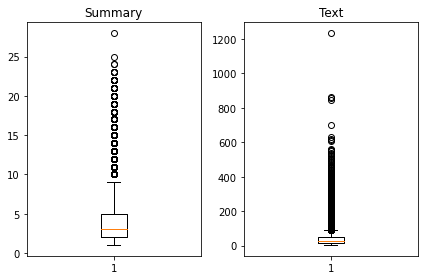

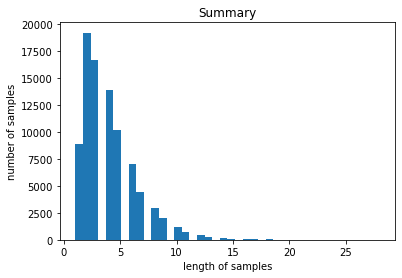

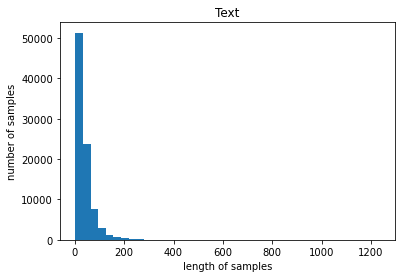

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰때는 데이터를 시각화하여 보는 것이 도움이 된다. 위에서 부터 차례대로 그래프는 각각 요약과 실제 텍스트의 길이 분포, 요약본 샘플 길이별 갯수, 실제 텍스트 샘플 길이별 갯수를 나타내고 있다.

Text의 경우 최소 길이가 2, 최대 길이가 1,235으로 그 차이가 굉장히 크다. 하지만 평균 길이는 38로 시각화 된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있다.

Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧다. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있는 모습이다.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해보자.

In [19]:
text_max_len = 50
summary_max_len = 8

각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는데 도움이 될것이다. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보자.

In [20]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

이렇게 만든 함수를 Text와 Summary에 적용해 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있다.

In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


각각 50과 8로 패딩을 하게되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 한다.

정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제해보자.

In [22]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


### 시작 토큰과 종료 토큰 추가하기
---
디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 것이다.

<img src="./image/encoder_decoder.png" alt="시작 토큰과 종료 토큰" />

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다. 이번 실습에서는 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명하고 앞, 뒤로 추가할 것이다. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했다. 두 개의 문장 모두 Summary 열로부터 만들것이다.

In [23]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


앞뒤로 토큰이 잘 붙은 모습이다. 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해주자.

In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

이제 훈련 데이터와 테스트 데이터를 분리할 것이다.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러가지 방법이 있을텐데 직접 해보도록 하자. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어주자.

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 2971 59998 39955 ... 25868 30105  6259]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 되겠다.

In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해주자. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해주면 된다.

In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13163


이렇게 정의한 테스트 데이터의 갯수를 이용해 전체 데이터를 양분하자. :표시의 위치에 주의해야한다.

In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


훈련 데이터와 테스트 데이터가 각각 52,655개와 13,163개로 잘 분리된 것을 볼 수 있다.

## 7. 데이터 전처리하기 (3) 정수 인코딩

### 단어 집합(vocaburary) 만들기 및 정수 인코딩
---
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다. 이 과정을 __단어 집합(vocaburary)__을 만든다고 표현한다. 훈련 데이터에 대해서 단어 집합을 만들어보자. 우선, 원문에 해당되는 `encoder_input_train`에 대해서 단어 집합을 만들자.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장되어있다. 그런데 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 한다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

`src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31991
등장 빈도가 6번 이하인 희귀 단어의 수: 23717
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8274
단어 집합에서 희귀 단어의 비율: 74.13647588384234
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.379323316850813


`encoder_input_train`에 총 32,021개의 단어가 있음을 확인할 수 있다. 그 아래의 통계 정보들을 해석해보자.

등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지한다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.38%밖에 되지 않는다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다. 위에서 이를 제외한 단어 집합의 크기를 8,262로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8000으로 제한해보자. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [31]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

`texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 현재 단어 집합의 크기를 8,000으로 제한했으니 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4093, 979, 475, 89, 123, 43, 548, 2791, 1520, 22, 231, 404, 43, 235, 431, 25, 953, 443, 2170, 7194], [13, 144, 108, 51, 67, 57, 439, 14, 36, 164, 74, 869, 642, 688, 6133, 3907, 29, 727, 300, 144, 651, 1357, 5080, 363, 90, 689, 586, 5, 10, 41, 745, 832, 1698, 5250], [140, 2, 915, 756, 2, 3828, 1, 251, 4177, 915, 84, 53, 97, 454, 53, 470, 75, 119, 128, 630, 307, 1261, 3193, 2338, 756, 74, 707, 1505, 141, 1302, 915, 756, 38, 15, 645, 63, 1620, 1773, 563, 3345, 1262, 112, 360, 1358]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있다.

Summary 데이터에 대해서도 동일한 작업을 수행해보자. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 이는 `tar_tokenizer.word_index`에 저장되어있다. `tar_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10493
등장 빈도가 5번 이하인 희귀 단어의 수: 8111
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2382
단어 집합에서 희귀 단어의 비율: 77.29915181549605
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.913788800633375


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고있다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않는다. 아까 했던것과 동일하게 이 단어들은 모두 제거하자. 2,391에서 어림잡아 2,000을 단어 집합의 크기로 제한해보자.

In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 205, 8, 87], [1, 3, 116, 18, 6, 92, 101], [1, 93, 4, 393, 319], [1], [1, 175, 10, 29]]
target
decoder  [[205, 8, 87, 2], [3, 116, 18, 6, 92, 101, 2], [93, 4, 393, 319, 2], [2], [175, 10, 29, 2]]


정상적으로 정수 인코딩 작업이 끝났다. 현재 `decoder_input_train`과 `decoder_target_train`에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않는다. 그런데 다음 작업인 패딩하기로 넘어가기 전에 한 가지 점검해야할 것이 있다.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높을 것이다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와보자. 여기서 주의할 점은 요약문인 `decoder_input`에는 `sostoken` 또는 `decoder_target`에는 `eostoken`이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않는다. 그래서 이제 길이가 0이 된 요약문의 실제길이는 1로 나올것이다. 길이 0이 된 `decoder_input`에는 `sostoken`, `decoder_target`에는 `eostoken`만 남아 있을 것이기 때문이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 `drop_train`과 `drop_test`에 라는 변수에 저장해보자. 이 샘플들은 모두 삭제할 것이다.

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1292
삭제할 테스트 데이터의 개수 : 317
훈련 데이터의 개수 : 51363
훈련 레이블의 개수 : 51363
테스트 데이터의 개수 : 12846
테스트 레이블의 개수 : 12846


/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있다.

### 패딩하기
---
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야한다. 아까 정해두었던 최대 길이로 패딩해 줄 것이다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주자.

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

이제 학습에 필요한 데이터 전처리가 모두 끝났다.

## 8. 모델 설계하기
이제 모델을 설계할 시간이다. 우선 함수형 API를 이용해서 인코더를 설계해보자.

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했다. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴론의 갯수라고 이해하면 된다. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야 할 것이다.

디코더를 설계해보자.

In [39]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.

디코더의 출력층을 설계해보자.

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 `tar_vocab`의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야한다. 그렇기 때문에 Dense의 인자로 `tar_vocab`을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq이다. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있다. 바로 어텐션 메커니즘이다.

### 어텐션 매커니즘
---
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻이다. 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 보자.

아래의 코드를 수행하여 깃허브에 공개되어져 있는 어텐션 함수를 다운로드 하자.



In [41]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

이제 경로에 attention.py 파일이 생겼으니, 어텐션 메커니즘을 사용할 준비가 되었다. 설계한 디코더의 출력층을 다음과 같이 수정하자.

In [42]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.

## 9. 모델 훈련하기
설계한 모델을 가지고 훈련을 진행해보자.

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
201/201 [==============================] - 71s 352ms/step - loss: 2.7018 - val_loss: 2.4091
Epoch 2/50
201/201 [==============================] - 70s 350ms/step - loss: 2.3896 - val_loss: 2.2891
Epoch 3/50
201/201 [==============================] - 71s 352ms/step - loss: 2.2557 - val_loss: 2.1583
Epoch 4/50
201/201 [==============================] - 71s 352ms/step - loss: 2.1311 - val_loss: 2.0761
Epoch 5/50
201/201 [==============================] - 72s 358ms/step - loss: 2.0453 - val_loss: 2.0166
Epoch 6/50
201/201 [==============================] - 72s 359ms/step - loss: 1.9822 - val_loss: 1.9780
Epoch 7/50
201/201 [==============================] - 73s 361ms/step - loss: 1.9308 - val_loss: 1.9486
Epoch 8/50
201/201 [==============================] - 73s 361ms/step - loss: 1.8847 - val_loss: 1.9227
Epoch 9/50
201/201 [==============================] - 72s 360ms/step - loss: 1.8443 - val_loss: 1.8973
Epoch 10/50
201/201 [==============================] - 72s 360ms/step - l

EarlyStopping은 한국어로 해석 하면 '조기 종료'의 뜻을 가지고 있는데, 특정 조건이 충족되면 모델의 훈련을 멈추는 역할을 한다. 여기서는 `val_loss(검증 데이터의 손실)`을 모니터링 하면서, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이`patiensce =2` 2회 관측되면 학습을 멈추도록 설정되어져 있다. 20번째 epoch쯤에서 조기종료되는 것을 확인했다.

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해보자.

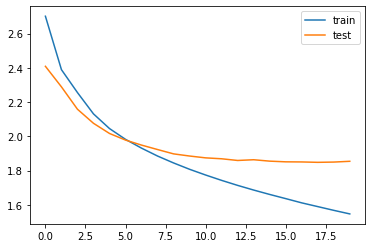

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 10. 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해두자.

In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계하자.

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들자.

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 11. 모델 테스트하기
테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편할 것이다. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보자. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외시키도록 만들것이다.

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자.

In [52]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : ordered product always satisfied welch fruit snacks always arrive exactly date indicated perfect quality 
실제 요약 : quality product always shipped on time 
예측 요약 :  great product


원문 : added sun blend raw plant based complete protein powder vanilla lbs bag protein shake amazing almost reeses peanut butter cup taste highly recommended 
실제 요약 : great in protein 
예측 요약 :  best tasting


원문 : unknown reasons item disappeared every local store shelf couple years ago found another brand amazon liked nothing tastes good kraft version thrilled see finally amazon less per nearly last time saw grocery store wow thank amazon 
실제 요약 : my favorite 
예측 요약 :  this is the best


원문 : food product best get school turn popcorn machine wait get hot cut whole bag popcorn start popping like minute popcorn taste good ingredients put bag right amount done might see pieces burnt popcorn hey least taste great 
실제 요약 : best popcorn no mess 
예측 요약 :  great northern popcorn


원문 : open bag prepare finish whol

예측 요약 :  great taste


원문 : good columbian average product average bean quality taste like pods use cheaper lower quality beans 
실제 요약 : good flavor and above average coffee bean quality 
예측 요약 :  good coffee


원문 : balsamic vinaigrette salad dressing good use steak sauce salad dressing though like use steaks balsamic vinaigrette tastes good 
실제 요약 : really good 
예측 요약 :  great seasoning


원문 : good service wish ordered sent quicker days ordered 
실제 요약 : it was good 
예측 요약 :  great gift


원문 : aussie loves nylabones anything else usually gets bigger bones gave one go carries around everywhere goes quite funny cute highly recommend item 
실제 요약 : dog loves this 
예측 요약 :  my dog loves these


원문 : large bars box huge big family size cereal times thick wish still offered original price expensive 
실제 요약 : big box big bars 
예측 요약 :  great product


원문 : appear first glance similar butters taste however lighter delicate infused hazelnut air cookie dip coffee becomes saturated rather quickly c

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미있는 요약들이 보인다. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있다. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과인 것이다.

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보인다 . 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재한다.

## 12. 추출적 요약 해보기
앞서 seq2seq를 통해서 추상적 요약을 진행해보았다. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었다.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있다. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀보자. 

### 패키지 설치
---
먼저 필요한 패키지를 아래와 같이 설치하자.

```bash
$ pip install summa
```

### 데이터 다운로드하기
---

In [53]:
import requests
from summa.summarizer import summarize

매트릭스 시놉시스를 다운로드한다.

In [54]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

text에는 매트릭스 시놉시스가 문자열로 저장되어져 있다. 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해보자.

In [55]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
---
Summa의 `summarize()`의 인자로 사용되는 값들에 대해서 알아보자.

* __text (str)__ : 요약할 테스트.
* __ratio (float, optional)__ – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* __words (int or None, optional)__ – 출력에 포함할 단어 수.
* 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* __split (bool, optional)__ – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여보자. 원문의 0.005%만을 출력해도록 설정했다.

In [56]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 된다.

In [57]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어의 수로 요약문의 크기를 조절할 수도 있다. 단어를 50개만 선택하도록 하자.

In [58]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
